In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy

BATCH_SIZE = 2000
SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW
IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)
Z_DIM = 128
BUF = 65536
DC_LR = 2.5e-04
DC_EPOCH = 256
W_LR = 2.0e-04
W_EPOCH = 256
BZ = (BATCH_SIZE, Z_DIM)
WClipLo = -0.01
WClipHi = 0.01

env: CUDA_VISIBLE_DEVICES=0


In [2]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.cast(img, tf.float32)  
    img = img / 255.0
    return img

In [3]:
import pathlib
img_dir = './img_align_celeba_png/'
data_dir = pathlib.Path(img_dir)
image_count = len(list(data_dir.glob('*.png')))

In [4]:
paths = [str(i) for i in list(data_dir.glob('*.png'))]

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((paths))
dataset = dataset.map(load_image)

In [6]:
dataset

<MapDataset shapes: (64, 64, 3), types: tf.float32>

In [7]:
dsTrain =dataset.batch(BATCH_SIZE,True)

In [8]:
dsTrain


<BatchDataset shapes: (2000, 64, 64, 3), types: tf.float32>

In [9]:
len(paths)

202599

In [10]:
# Utility function
def utPuzzle(imgs, row, col, path = None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [11]:
def GAN(sp, zd):
    # Shape
    xh, xw, xc = sp
    zh = xh // 4
    zw = xw // 4
        
    # Model
    return keras.Sequential([
        keras.layers.Dense(units  =  1024, input_shape = (zd,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = sp,
        ),
        keras.layers.LeakyReLU(),
        #keras.layers.Dropout(0.3),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        #keras.layers.Dropout(0.3),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [12]:
from functools import partial
Improved_W_LR = 1.0e-04
Improved_W_EPOCH = 256
grad_penalty_weight = 10
n_critic = 5

In [13]:
def gradient_penalty(f, real, fake):
    alpha = tf.random.uniform([BATCH_SIZE, 1, 1, 1], 0., 1.)
    diff = fake - real
    inter = real + (alpha * diff)
    with tf.GradientTape() as t:
        t.watch(inter)
        pred = f(inter)
    grad = t.gradient(pred, [inter])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2, 3]))
    gp = tf.reduce_mean((slopes - 1.)**2)
    return gp

In [14]:
Improved_WG, Improved_WD = GAN(IMG_SHAPE, Z_DIM)
opg = keras.optimizers.Adam(learning_rate = Improved_W_LR, beta_1=0, beta_2=0.9)
opd = keras.optimizers.Adam(learning_rate = Improved_W_LR, beta_1=0, beta_2=0.9)

@tf.function
def Improved_WGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        c0 = Improved_WG(z, training = True)
        
        #true
        z1 = Improved_WD(c1, training = True)
        #fake
        z0 = Improved_WD(c0, training = True)
        #loss
        loss = -tf.reduce_mean(z0)
        #cost
        fake_loss = tf.reduce_mean(z0)
        real_loss = tf.reduce_mean(z1)
        cost = fake_loss - real_loss
        gp = gradient_penalty(partial(Improved_WD, training=True), c1, c0)
        cost += grad_penalty_weight * gp

    gg = tpg.gradient(loss, Improved_WG.trainable_variables)

    opg.apply_gradients(zip(gg, Improved_WG.trainable_variables))
    
    return loss, cost

@tf.function
def Improved_WDTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        
        
        c0 = Improved_WG(z, training = True)
        
        #true
        z1 = Improved_WD(c1, training = True)
        #fake
        z0 = Improved_WD(c0, training = True)
        #loss
        loss = -tf.reduce_mean(z0)
        #cost
        fake_loss = tf.reduce_mean(z0)
        real_loss = tf.reduce_mean(z1)
        cost = fake_loss - real_loss
        gp = gradient_penalty(partial(Improved_WD, training=True), c1, c0)
        cost += grad_penalty_weight * gp

    gd = tpd.gradient(cost, Improved_WD.trainable_variables)

    opd.apply_gradients(zip(gd, Improved_WD.trainable_variables))
    
    return loss, cost

Improved_WTrain = (
    Improved_WDTrain,
    Improved_WDTrain,
    Improved_WDTrain,
    Improved_WDTrain,
    Improved_WDTrain,
    Improved_WGTrain
)

WCritic = len(Improved_WTrain)

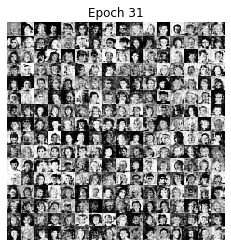

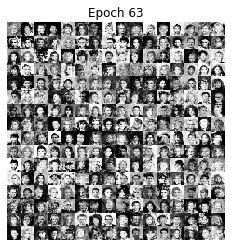

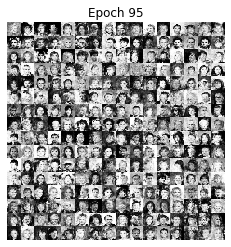

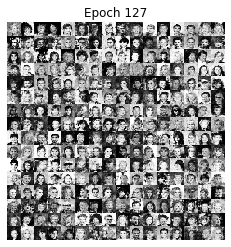

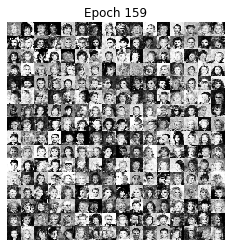

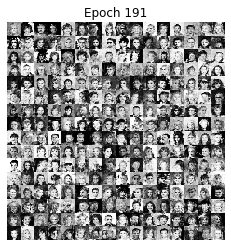

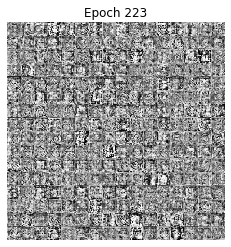

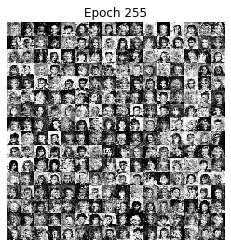

In [15]:
wlg = [None] * W_EPOCH
wld = [None] * W_EPOCH
wsp = [None] * W_EPOCH
rsTrain = float(BATCH_SIZE) / float(len(paths))
ctr = 0
for ep in range(Improved_W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = Improved_WTrain[ctr](c1)
        ldt += ld.numpy()
        lgt += lg.numpy()
        ctr += 1
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = Improved_WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/w_%04d.png" % ep
    )
    wsp[ep] = img
    if ep & 0x1F == 0x1F:
        
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [16]:
utMakeGif(np.array(wsp), "imgs/wganGP_celeba.gif", duration = 2)

t:   1%|          | 2/256 [00:00<00:17, 14.51it/s, now=None]

MoviePy - Building file imgs/wganGP_celeba.gif with imageio.


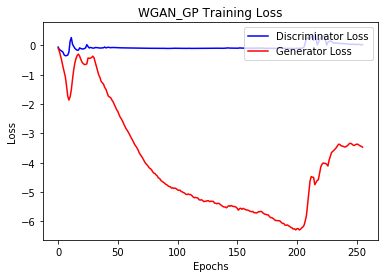

In [17]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN_GP Training Loss")
plt.show()

<h1>Result</h1>

<h3>report</h3>
這次的結果有點出乎我的預期，因為並不是train愈久愈好，從 20 epoch開始其實差不多臉型就出來了，之後就愈來愈像人臉，但在大約 200 epoch開始圖就又開始變得模糊了(從loss function也能看出來)，原本想測一下調參數的影響，但因為train一次要快20個小時，來不及趕上deadline，所以沒辦法確定是我的寫法不正確，還是這是GAN本身的性質